In [ ]:
import warnings
warnings.filterwarnings("ignore")

We will check the performance of different feature maps so that we can see their effect when used in combination with classical models. This is part of the implicit model scheme outlines in [Quantum machine learning in feature Hilbert spaces](https://arxiv.org/pdf/1803.07128.pdf)

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()

We will normalize the features so that they are in a comparable regime.

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(iris.data)

Given that the original dataset is a multiclass task we will make it binary to ease the work for now. It will also allow us to select the hardness of the problem, for dramatic effects. One important thing here is that we are going to split the dataset into *training* and *testing* datasets so that an unbiased metric can be obtained regarding model fitness. 

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

X_idx = np.where(iris.target < 2)
X = X_scaled[X_idx]
Y = iris.target[X_idx]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

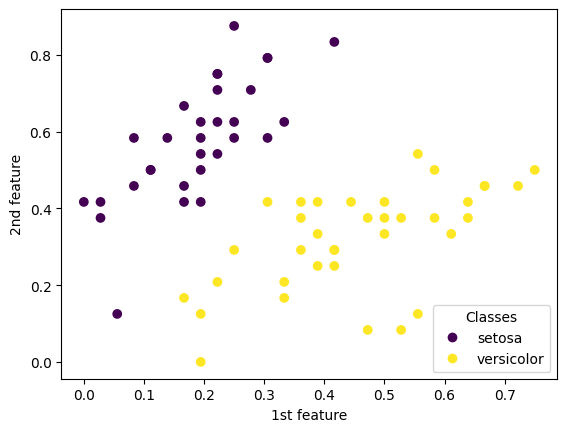

In [5]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
ax.set(xlabel="1st feature", ylabel="2nd feature")
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names[0:len(y_train)], loc="lower right", title="Classes"
)

Now, we could look for a trainable embedding so that we can tune the embedding to maximize the outcome.

In [6]:
import pennylane as qml
import pennylane.numpy as np

def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    n_wires = len(wires)
    for p, w in zip(params[1], wires):
        qml.CRZ(p, wires=[w % n_wires, (w + 1) % n_wires])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

adjoint_ansatz = qml.adjoint(ansatz)

def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

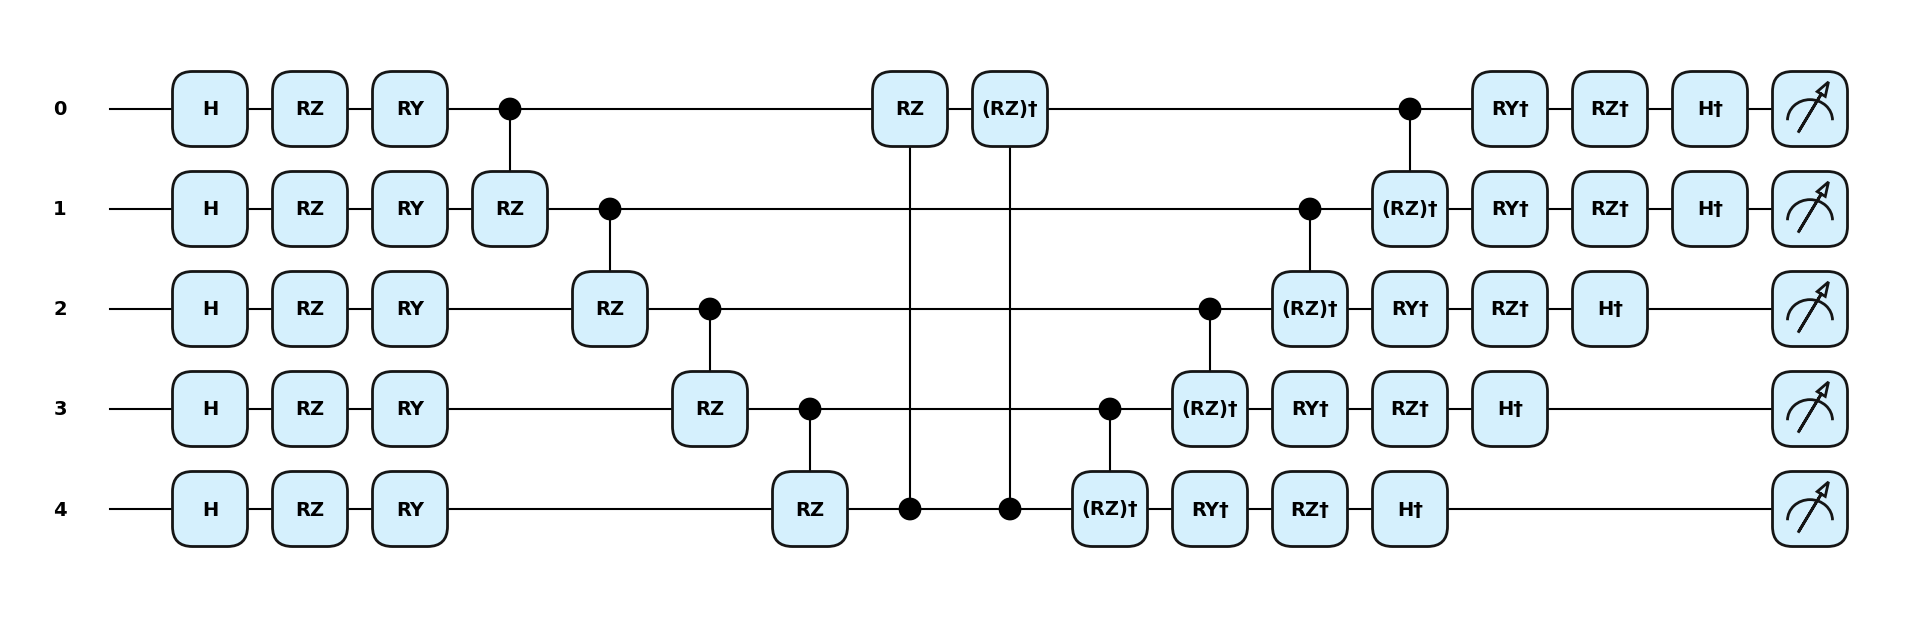

In [7]:
qml.drawer.use_style("pennylane")

params = random_params(num_wires=5, num_layers=1)
fig, ax = qml.draw_mpl(kernel_circuit)(X_scaled[0], X_scaled[0], params)

Let's look to maximize the separability between the two target classes.

$$

KTA_y = \frac{Tr(Kyy^T)}{\sqrt{Tr(K^2)Tr((yy^T)^2)}}

$$

where $K$ refers to the kernel matrix and $yy^T$ as the outcome of the two targets.

In [8]:
init_kernel = lambda x1, x2: kernel_circuit(x1, x2, params)
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.761


Extending the layers may actually help, due to this extra expressivity.

In [10]:
params = random_params(num_wires=5, num_layers=3)
init_kernel = lambda x1, x2: kernel_circuit(x1, x2, params)
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.823


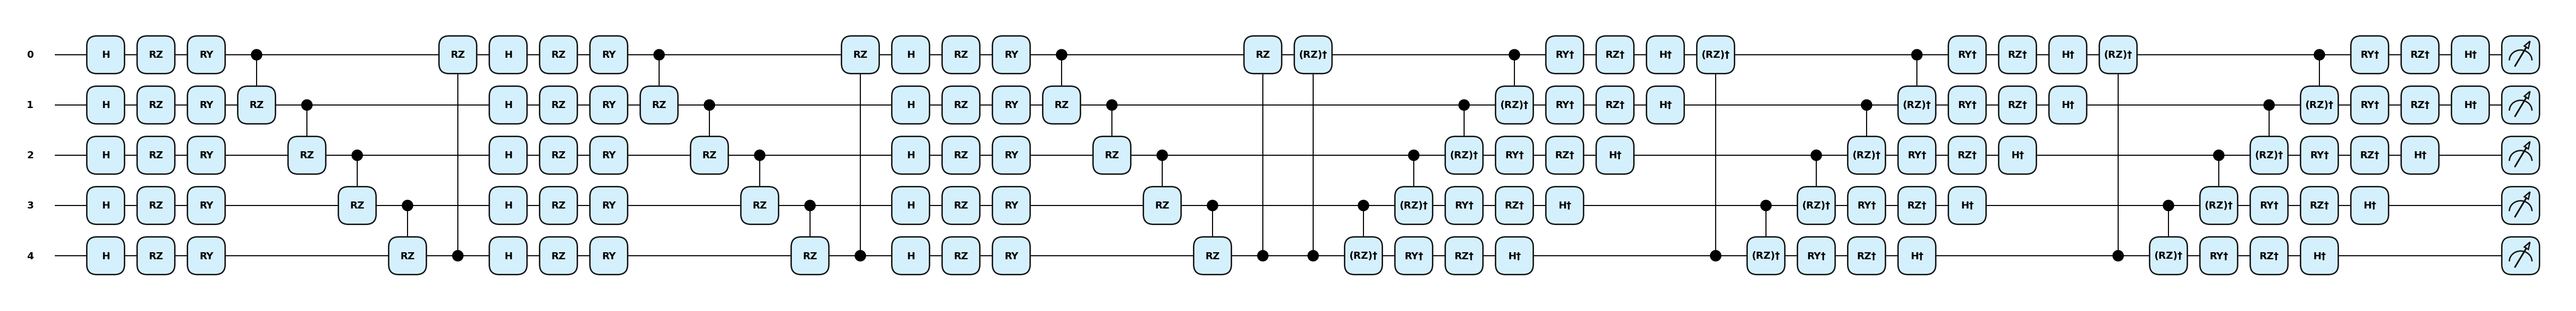

In [11]:
fig, ax = qml.draw_mpl(kernel_circuit)(X_scaled[0], X_scaled[0], params)